# CSCE 623 Homework Assignment 2
## Student Name: David Crow
## Date: 22 April 2019

In [1]:
"""
HW2
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## STEP 1:
Load the dataset

In [2]:
# the files are called 'datset<n>.csv,' where 'n' is a number between 1 and 3
# I changed the names to 'dataset<n>.csv' under the assumption that 'datset' is a typo
# if you meant to prefix them with 'datset,' just change the prefix variable below from 'dataset' to 'datset'

prefix = "dataset"

df1 = pd.read_csv(prefix + "1.csv", index_col=0)
df2 = pd.read_csv(prefix + "2.csv", index_col=0)
df3 = pd.read_csv(prefix + "3.csv", index_col=0)

## STEP 2:
Explore the dataset

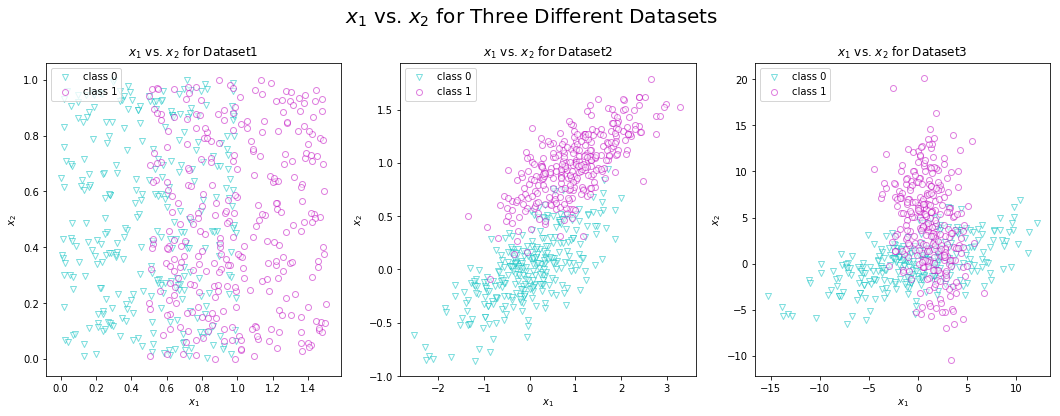

In [3]:
# create the overall figure
fig = plt.figure(figsize=(18,6))
fig.suptitle('$x_1$ vs. $x_2$ for Three Different Datasets', fontsize=20)
fig.subplots_adjust(top=0.85)

# we need three subplots (one for each dataset)
ax = [
    fig.add_subplot(131),
    fig.add_subplot(132),
    fig.add_subplot(133)
]

# n iterates through the different subplots
n = 0

# for each dataset...
for df in (df1, df2, df3):
    # plot the current dataset on the nth subplot
    ax[n].scatter(df[df['2'] == 0]['0'], df[df['2'] == 0]['1'], label="class 0", marker='v', alpha=0.5, edgecolors='c', facecolors='w')
    ax[n].scatter(df[df['2'] == 1]['0'], df[df['2'] == 1]['1'], label="class 1", marker='o', alpha=0.5, edgecolors='m', facecolors='w')
    
    # pretty-fy the nth subplot
    ax[n].set_title("$x_1$ vs. $x_2$ for Dataset" + str(n + 1))
    ax[n].set_xlabel("$x_1$")
    ax[n].set_ylabel("$x_2$")
    ax[n].legend(loc=2)

    n += 1

## Step 3:

#### What do you notice about the distribution of the data?

- Dataset 1
    - $x_1$ is uniformly distributed between 0.0 and 1.0 for class 0 and between 0.5 and 1.5 for class 1
    - $x_2$ is uniformly distributed between 0.0 and 1.0 for both classes
- Dataset 2
    - $x_1$ is normally distributed between -2 and 2 for class 0 (plus a few obvious outliers) and between -1.5 and 3.5 for class 1
    - $x_2$ is normally distributed between -1 and 1 for class 0 and between 0 and 2 (plus one obvious outlier) for class 1
- Dataset 3
    - $x_1$ is normally distributed between -15 and 15 for class 0 and between -5 and 5 (plus a few obvious outliers) for class 1
    - $x_2$ is normally distributed between -7.5 and 7.5 for class 0 and between -7.5 and 20 (plus a few obvious outliers) for class 1

#### What can you say about the covariance of the two classes?
- Dataset 1
    - This dataset has a covariance near zero. Although the features follow similar distributions for the two classes, the overlap in values means the positive and negative covariance values cancel out (this is how I understand covariance).
- Dataset 2
     - As I understand it, this dataset has high covariance. They features seem to be distributed in about the same way for the two classes, and the two classes just look like they change in the same way (e.g. similar orientation, but class 1 is just shifted up and to the right). 
- Dataset 3
    - This dataset has low covariance. The features are not distributed similarly in the two classes, and there is also a fair amount of overlap.

#### Between classes, are the variances of a single feature equal? 
- Dataset 1
    - The variance of both features is about the same between class 0 and class 1 (that is, class 1's $x_1$ variance is about the same as class 0's $x_1$ variance, and the same holds for $x_2$).
- Dataset 2
    - Like in dataset 1, the variance of both features is about the same between the two classes.
- Dataset 3
    - The variances of each feature between classes are not equal. In fact, class 1's $x_1$ variance is about the same as class 0's $x_2$ variance (and vice versa), but the two $x_1$ (and $x_2$) variances are definitely not similar.

#### How well are the classes separated?
- Dataset 1
    - These classes are not very separate at all. In fact, about half of the class 0 datapoints overlap about half of the class 1 datapoints. Our classifiers might have a hard time fitting this dataset. Outside of this middle band of overlaps, however, the classifiers should do well.
- Dataset 2
    - These classes are fairly separate. Although there is certainly some overlap in the classes, they are mostly distinct.
- Dataset 3
    - Like in dataset 1, there is a fairly large section in this plot where class 0 and class 1 overlap. Outside this section, the classes are well separated, but inside this region, our classifiers will struggle.

#### Which predictor do you think will work best under this condition (Logistic Regression, LDA, or QDA)… and why? 
- Dataset 1
    - I think that none of the predictors will work incredibly well, but I also think they'll all perform about the same (assuming QDA can fit a relatively "flat" quadratic boundary). None of the assumptions of the various models are violated, so there's no reason to think one will perform worse than the others.
- Dataset 2
    - Again, I think the three predictors will perform about the same. None of the assumptions are violated, and the classes aren't too separated as to make Logistic Regression perform poorly. If I had to pick one, I'd say that QDA might perform a tiny bit better because it could fit its boundary to the curved "edge" of either class 0 or class 1. I don't think the improvement will be significant, though.
- Dataset 3
    - Because LR and LDA can only fit straight lines, neither one is going to perform incredibly well here. There's just no good way to draw a line through this plot. I don't think one will have an advantage over the other, either. However, QDA will likely perform much better. Although it will make some mistakes within the overlapping region, it can at least make sure the line curves around class 1 so as to limit the amount of class 0 overlap inside the class 1 boundary. QDA won't be perfect here, but it'll definitely be better than LR and LDA.

## Step 4:
Define a function to split the dataset into test and training data

In [4]:
# df: the dataset we wish to split
# number_of_training_points: the number of points we'd like to use for training
def splitDataset(df, number_of_training_points):
    # compute the percentage of points to take (from each class) for training
    train_ratio = number_of_training_points / df.shape[0]
    
    # pull proportionate numbers of points from class 0 and class 1
    train0 = df[df['2'] == 0].sample(frac=train_ratio)
    train1 = df[df['2'] == 1].sample(frac=train_ratio)
    
    # combine the training points for each class into one training set (dataframe)
    train = train0.append(train1)
    
    # the set of testing points consists of all points not already selected for training
    # so we can combine the original dataframe and the training dataset and remove all duplicates
    # 'keep=False' ensures we remove all observations in a set of duplicate observations
    test = pd.concat([df, train]).drop_duplicates(keep=False)
    
    return train, test

## Step 5:
Fit each of {LR, LDA, QDA} to each dataset

#### We need to split the datasets before fitting any models.
Let's define three lists: `df1_models`, `df2_models`, and `df3_models`. Each list will contain three items: an LR model, an LDA model, and a QDA model. We're structuring our code this way to reduce duplicate code and to combine similar items into fewer data structures.

When all is said and done, we can access, for example, QDA for dataset 3 with `df3_models[2]`. This should allow for cleaner code. However, we do lose a little bit of simplicity.

In [5]:
# split all three datasets into testing/training datasets
train1, test1 = splitDataset(df1, df1.shape[0] / 2)
train2, test2 = splitDataset(df2, df2.shape[0] / 2)
train3, test3 = splitDataset(df3, df3.shape[0] / 2)

# 0: LR, 1: LDA, 2: QDA
df1_models = []
df2_models = []
df3_models = []

#### Fit a model to the training set for Logistic Regression.

In [6]:
# dataset 1
df1_models.append(LogisticRegression(solver="newton-cg"))
df1_models[0].fit(train1[["0", "1"]], train1[["2"]].values.ravel())

# dataset 2
df2_models.append(LogisticRegression(solver="newton-cg"))
df2_models[0].fit(train2[["0", "1"]], train2[["2"]].values.ravel())

# dataset 3
df3_models.append(LogisticRegression(solver="newton-cg"))
df3_models[0].fit(train3[["0", "1"]], train3[["2"]].values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

#### Fit a model to the training set for Linear Discriminant Analysis.

In [7]:
# dataset 1
df1_models.append(LinearDiscriminantAnalysis())
df1_models[1].fit(train1[["0", "1"]], train1[["2"]].values.ravel())

# dataset 2
df2_models.append(LinearDiscriminantAnalysis())
df2_models[1].fit(train2[["0", "1"]], train2[["2"]].values.ravel())

# dataset 3
df3_models.append(LinearDiscriminantAnalysis())
df3_models[1].fit(train3[["0", "1"]], train3[["2"]].values.ravel())

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

#### Fit a model to the training set for Quadratic Discriminant Analysis.

In [8]:
# dataset 1
df1_models.append(QuadraticDiscriminantAnalysis())
df1_models[2].fit(train1[["0", "1"]], train1[["2"]].values.ravel())

# dataset 2
df2_models.append(QuadraticDiscriminantAnalysis())
df2_models[2].fit(train2[["0", "1"]], train2[["2"]].values.ravel())

# dataset 3
df3_models.append(QuadraticDiscriminantAnalysis())
df3_models[2].fit(train3[["0", "1"]], train3[["2"]].values.ravel())

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

## Step 6:
For each classifier, use the test set to determine the probabilities for which each classifier believes each datapoint belongs to class 1

In [9]:
probs1 = []
probs2 = []
probs3 = []

# for each model...
for i in range(3):
    # for a given classifer, we need to predict the probability of each class in our training set
    # we then need to select only the column that contains the probabilities for class 1
    probs1.append(df1_models[i].predict_proba(test1[["0", "1"]])[:,1])
    probs2.append(df2_models[i].predict_proba(test2[["0", "1"]])[:,1])
    probs3.append(df3_models[i].predict_proba(test3[["0", "1"]])[:,1])

probs1 = np.array(probs1)
probs2 = np.array(probs2)
probs3 = np.array(probs3)

## Step 7:
Define `getROCdata(truthVals, probs, thresholds)`

In [10]:
# truthVals: the actual classifications of all test datapoints
# probs: the probability of a datapoint being in class 1, for each datapoint, under our model
# thresholds: a set of probability thresholds to test
def getROCdata(truthVals, probs, thresholds):
    # true/false positive/negative count
    tpc = []
    fpc = []
    tnc = []
    fnc = []
    
    # for each threshold...
    for threshold in thresholds:
        preds = probs.copy()

        # check whether each element is greater than or equal to the threshold
        # then convert the boolean values into 0s and 1s
        preds = (preds > threshold).astype(int)

        # if we scale up our predictions, then we can
        # sum our truthVals and predictions and identify true/false positives/negatives
        weighted_sum = 10 * preds + np.array(truthVals).ravel()

        # num_freqs stores each unique number as a key
        # and the frequency of that number as the key's value
        num, counts = np.unique(weighted_sum, return_counts=True)
        num_freqs = dict(zip(num, counts))

        # if the key doesn't exist in the dict, Python says the value is None
        # so we replace all None values with 0
        tpc.append(0 if num_freqs.get(11) is None else num_freqs.get(11)) # prediction: 10, actual: 1
        fpc.append(0 if num_freqs.get(10) is None else num_freqs.get(10)) # prediction: 10, actual: 0
        fnc.append(0 if num_freqs.get(1) is None else num_freqs.get(1))   # prediction:  0, actual: 1
        tnc.append(0 if num_freqs.get(0) is None else num_freqs.get(0))   # prediction:  0, actual: 0

    tpc = np.array(tpc).reshape(-1,1)
    fpc = np.array(fpc).reshape(-1,1)
    tnc = np.array(tnc).reshape(-1,1)
    fnc = np.array(fnc).reshape(-1,1)
    
    # create an array of 1s to avoid divide-by-zero errors
    tpr = np.zeros((len(thresholds))).reshape(-1,1)
    fpr = np.zeros((len(thresholds))).reshape(-1,1)
    prec = np.zeros((len(thresholds))).reshape(-1,1)
    f1 = np.zeros((len(thresholds))).reshape(-1,1)
    
    # if the denominator isn't 0, update with the actual value
    np.divide(tpc, tpc + fnc, out=tpr, where=(tpc + fnc)!=0)
    np.divide(fpc, fpc + tnc, out=fpr, where=(fpc + tnc)!=0)
    np.divide(tpc, tpc + fpc, out=prec, where=(tpc + fpc)!=0)
    np.divide(2 * prec * tpr, prec + tpr, out=f1, where=(prec + tpr)!=0)
    
    # compute accuracy (practically, no divide by zero possibility here)
    acc = (tpc + tnc) / len(truthVals)
    
    # combine and return the individual columns
    data = np.hstack((thresholds.ravel().reshape(-1,1), tpc, fpc, tnc, fnc, tpr, fpr, acc, prec, f1))
    
    return pd.DataFrame(data, columns = [
        'Probability Threshold',
        'True Positive Count',
        'False Positive Count',
        'True Negative Count',
        'False Negative Count',
        'True Positive Rate',
        'False Positive Rate',
        'Accuracy',
        'Precision',
        'F-Measure'
    ])

## Step 8:
For each model, generate a vector of 100 probability threshold values to test; call `getROCdata()` to obtain the response

In [11]:
thresholds1 = []
thresholds2 = []
thresholds3 = []

# for each dataset...
for i in range(3):
    # generate threshold values from the minimum probability to the second largest unique probability
    # this ensures we don't have any degenerate predictions
    # specifically, sort the probabilities and grab the 2nd smallest unique value
    thresholds1.append(np.linspace(probs1[i].min(), np.sort(np.unique(probs1[i]))[-2], 100))
    thresholds2.append(np.linspace(probs2[i].min(), np.sort(np.unique(probs2[i]))[-2], 100))
    thresholds3.append(np.linspace(probs3[i].min(), np.sort(np.unique(probs3[i]))[-2], 100))

thresholds1 = np.array(thresholds1)
thresholds2 = np.array(thresholds2)
thresholds3 = np.array(thresholds3)

# couldn't easily reduce redundant code below
# it only works as expected when I explicitly call the function each time

# dataset 1
roc1_lr = getROCdata(test1[["2"]], probs1[0], thresholds1[0])
roc1_lda = getROCdata(test1[["2"]], probs1[1], thresholds1[1])
roc1_qda = getROCdata(test1[["2"]], probs1[2], thresholds1[2])

# dataset 2
roc2_lr = getROCdata(test2[["2"]], probs2[0], thresholds2[0])
roc2_lda = getROCdata(test2[["2"]], probs2[1], thresholds2[1])
roc2_qda = getROCdata(test2[["2"]], probs2[2], thresholds2[2])

# dataset 3
roc3_lr = getROCdata(test3[["2"]], probs3[0], thresholds3[0])
roc3_lda = getROCdata(test3[["2"]], probs3[1], thresholds3[1])
roc3_qda = getROCdata(test3[["2"]], probs3[2], thresholds3[2])

## Step 9:
Plot Receiver Operating Characteristics (ROC) curves for each of the three classifiers on a single plot

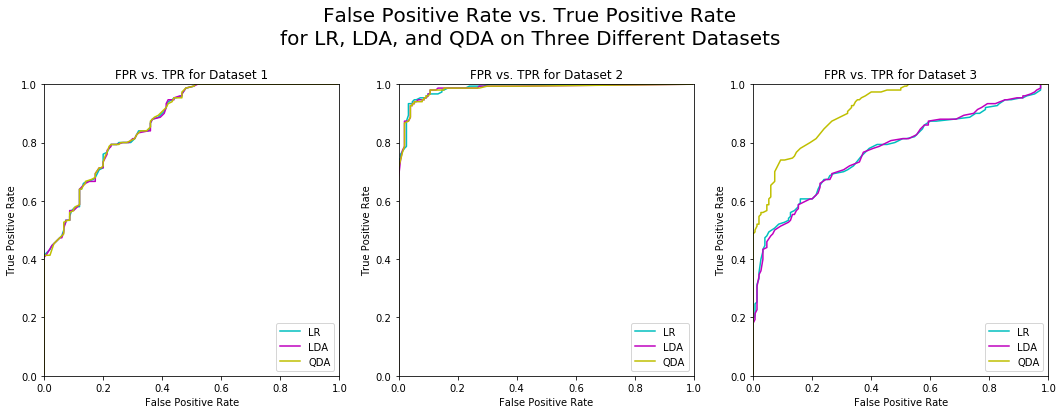

In [12]:
# create the overall figure
fig = plt.figure(figsize=(18,6))
fig.suptitle('False Positive Rate vs. True Positive Rate\nfor LR, LDA, and QDA on Three Different Datasets', fontsize=20)
fig.subplots_adjust(top=0.8)

# we need three subplots (one for each dataset)
ax = [
    fig.add_subplot(131),
    fig.add_subplot(132),
    fig.add_subplot(133)
]

# we use these to better annotate our models
labels = {0: 'LR', 1: 'LDA', 2: 'QDA'}
colors = {'LR': 'c', 'LDA': 'm', 'QDA': 'y'}

# dataset 1
n = 0
for r in (roc1_lr, roc1_lda, roc1_qda):
    ax[0].plot(r['False Positive Rate'], r['True Positive Rate'], label=labels[n], color=colors[labels[n]])
    n += 1

# dataset 2
n = 0
for r in (roc2_lr, roc2_lda, roc2_qda):
    ax[1].plot(r['False Positive Rate'], r['True Positive Rate'], label=labels[n], color=colors[labels[n]])
    n += 1

# dataset 3
n = 0
for r in (roc3_lr, roc3_lda, roc3_qda):
    ax[2].plot(r['False Positive Rate'], r['True Positive Rate'], label=labels[n], color=colors[labels[n]])
    n += 1

# pretty-fy the plots
for i in range(3):
    ax[i].axis([0, 1, 0, 1])
    ax[i].set_title("FPR vs. TPR for Dataset " + str(i + 1))
    ax[i].set_xlabel("False Positive Rate")
    ax[i].set_ylabel("True Positive Rate")
    ax[i].legend(loc=4)

## Step 10:
Develop a function to compute Area Under the Curve (AUC) for ROCs

In [13]:
# fpr: a set of the false positive rate values for our thresholds
# tpr: a set of the true positive rate values for our thresholds
def areaUnderCurve(fpr, tpr):
    area = 0
    
    # for each (fpr, tpr) point except the last...
    for i in range(len(fpr) - 1):
        # add the area of the trapezoid formed by (fpr, tpr) and y = 0
        area += 0.5 * abs(fpr[i] - fpr[i + 1]) * (tpr[i] + tpr[i + 1])
    
    # add the area of the trapezoid formed by (0, 0) and the first (fpr, tpr) point
    area += 0.5 * abs(fpr.iat[-1] - 0) * (0 + tpr.iat[-1])

    # add the area of the trapezoid formed by the last (fpr, tpr) point and (1, 1)
    area += 0.5 * abs(1 - fpr[0]) * (tpr[0] + 1)

    return area

Report the AUC for each classifier

In [14]:
auc1 = []
auc2 = []
auc3 = []

# dataset 1
for r in (roc1_lr, roc1_lda, roc1_qda):
    auc1.append(areaUnderCurve(r['False Positive Rate'], r['True Positive Rate']))

# dataset 2
for r in (roc2_lr, roc2_lda, roc2_qda):
    auc2.append(areaUnderCurve(r['False Positive Rate'], r['True Positive Rate']))

# dataset 3
for r in (roc3_lr, roc3_lda, roc3_qda):
    auc3.append(areaUnderCurve(r['False Positive Rate'], r['True Positive Rate']))
    
# put the AUCs into a labeled dataframe
auc = pd.DataFrame(
    np.vstack((auc1, auc2, auc3)),
    columns=['LR AUC', 'LDA AUC', 'QDA AUC'],
    index=['Dataset 1', 'Dataset 2', 'Dataset 3']
)

auc

,LR AUC,LDA AUC,QDA AUC
Dataset 1,0.873867,0.873311,0.873822
Dataset 2,0.986333,0.983756,0.983267
Dataset 3,0.773022,0.772933,0.914200


#### State your assumptions about how you built the AUC computation.
I approximate the AUC with the trapezoidal rule. I assume that the FPR values are distributed relatively evenly between 0 and 1; this will reduce the possibility of my trapezoids significantly over- or underestimating.

Of course, the trapezoidal rule is an approximation, so it can't perfectly estimate the area under the curve - for example, we know our ROC curve isn't necessarily straight between `(fpr[i], tpr[i])` and `(fpr[i + 1], tpr[i + 1])`. However, my approximations are nearly identical to scikit-learn's AUC approximations (not shown). Thus, we can trust that my AUC values are accurate.

We were also asked to ensure our AUC calculations extend from x = 0 to x = 1. Because the threshold values for False Positive Rate don't necessarily extend all the way to 0 and 1, I had to improvise a bit. Specifically, I place two final (fpr, tpr) points on the ROC plot, one at (0, 0) and one at (1, 1). Under the assumption that the ends of the ROC curve are already close to these values (which we can verify by inspecting the plot), these additional points don't significantly impact the AUC (barely at all, really), and they ensure that we are reporting the AUC over the entire 0:1 range.

## Step 11:
For each model, determine the probability threshold(s) for which each of {Accuracy, Precision, Recall, F-Measure} is maximized

In [15]:
best_thresholds1 = []
best_thresholds2 = []
best_thresholds3 = []

# useful for labeling
attrs = {0: 'Accuracy', 1: 'Precision', 2: 'True Positive Rate', 3: 'F-Measure'}

""" 
dataset 1
"""

n = 0

# for each model...
for r in (roc1_lr, roc1_lda, roc1_qda):
    # we need four threshold values per model
    best_thresholds1.append([])
    
    # for each attribute...
    for i in range(len(attrs)):
        # build a dataframe from `r` that only contains rows in which the attribute is maximized
        r_attr = r[r[attrs[i]] == r[attrs[i]].max()]
        
        # grab the minimum threshold from this new dataframe
        # (in case multiple thresholds achieve the max attribute)
        best_thresholds1[n].append(r_attr['Probability Threshold'].min())

    n += 1

# put the thresholds into a labeled dataframe
best_thresholds1 = pd.DataFrame(
    np.array(best_thresholds1).T,
    columns=['LR', 'LDA', 'QDA'],
    index=[attrs[0], attrs[1], attrs[2], attrs[3]]
)

""" 
dataset 2
"""

n = 0

# for each model...
for r in (roc2_lr, roc2_lda, roc2_qda):
    # we need four threshold values per model
    best_thresholds2.append([])
    
    # for each attribute...
    for i in range(len(attrs)):
        # build a dataframe from `r` that only contains rows in which the attribute is maximized
        r_attr = r[r[attrs[i]] == r[attrs[i]].max()]
        
        # grab the minimum threshold from this new dataframe
        # (in case multiple thresholds achieve the max attribute)
        best_thresholds2[n].append(r_attr['Probability Threshold'].min())

    n += 1

# put the thresholds into a labeled dataframe
best_thresholds2 = pd.DataFrame(
    np.array(best_thresholds2).T,
    columns=['LR', 'LDA', 'QDA'],
    index=[attrs[0], attrs[1], attrs[2], attrs[3]]
)

""" 
dataset 3
"""

n = 0

# for each model...
for r in (roc3_lr, roc3_lda, roc3_qda):
    # we need four threshold values per model
    best_thresholds3.append([])
    
    # for each attribute...
    for i in range(len(attrs)):
        # build a dataframe from `r` that only contains rows in which the attribute is maximized
        r_attr = r[r[attrs[i]] == r[attrs[i]].max()]
        
        # grab the minimum threshold from this new dataframe
        # (in case multiple thresholds achieve the max attribute)
        best_thresholds3[n].append(r_attr['Probability Threshold'].min())

    n += 1

# put the thresholds into a labeled dataframe
best_thresholds3 = pd.DataFrame(
    np.array(best_thresholds3).T,
    columns=['LR', 'LDA', 'QDA'],
    index=[attrs[0], attrs[1], attrs[2], attrs[3]]
)

display(best_thresholds1)
display(best_thresholds2)
display(best_thresholds3)

,LR,LDA,QDA
Accuracy,0.454677,0.424122,0.420349
Precision,0.732544,0.797528,0.803450
True Positive Rate,0.037876,0.011411,0.017603
F-Measure,0.250908,0.178461,0.184595


,LR,LDA,QDA
Accuracy,0.675542,6.262623e-01,6.767677e-01
Precision,0.836531,9.898985e-01,9.898989e-01
True Positive Rate,0.001399,8.467232e-08,2.404394e-07
F-Measure,0.675542,6.262623e-01,6.767677e-01


,LR,LDA,QDA
Accuracy,0.537808,0.479445,5.252525e-01
Precision,0.852772,0.838686,9.090909e-01
True Positive Rate,0.065362,0.064935,5.009834e-16
F-Measure,0.398853,0.405754,2.828283e-01


Report a confusion matrix table of predicted class vs. true class

In [16]:
# best_thresholds: a set of thresholds that maximize various metrics in our model
# model: a string that represents a model {LR, LDA, QDA}
# roc: a dataframe with ROC data
# dataset: the number of the dataset associated with the previous parameters
def confusionMatrix(best_thresholds, model, roc, dataset):
    # for each unique minimum threshold for a given model...
    for threshold in best_thresholds[model].unique():
        # find the observation with the threshold in question
        o = roc[roc['Probability Threshold'] == threshold]

        # pull the true/false positive/negative counts from the row
        tpc = np.asscalar(o['True Positive Count'])
        fpc = np.asscalar(o['False Positive Count'])
        tnc = np.asscalar(o['True Negative Count'])
        fnc = np.asscalar(o['False Negative Count'])

        # sum the predicted/actual positive/negative values
        # additionally, compute the totals
        ppc = tpc + fpc
        pnc = fnc + tnc
        apc = tpc + fnc
        anc = fpc + tnc
        total = apc + anc

        # build and annotate a dataframe
        confusion = pd.DataFrame(
            np.array([(tpc, fpc, ppc), (fnc, tnc, pnc), (apc, anc, total)]),
            columns=['aP', 'aN', 'total'],
            index=['pP', 'pN', 'total']
        )
        
        # save the attributes that `threshold` maximizes and then convert the list into a string
        maximized = best_thresholds[best_thresholds[model] == threshold].index
        maximized = np.array2string(maximized)

        # output the matrix
        print("------ Dataset   : " + str(dataset))
        print("------ Model     : " + model)
        print("------ Threshold : " + str(np.asscalar(threshold)))
        print("------ Maximizes : " + maximized + "\n")
        print(confusion)
        print("\n------------------------------------------\n")

# dataset 1
confusionMatrix(best_thresholds1, 'LR', roc1_lr, 1)
confusionMatrix(best_thresholds1, 'LDA', roc1_lda, 1)
confusionMatrix(best_thresholds1, 'QDA', roc1_qda, 1)

# dataset 2
confusionMatrix(best_thresholds2, 'LR', roc2_lr, 2)
confusionMatrix(best_thresholds2, 'LDA', roc2_lda, 2)
confusionMatrix(best_thresholds2, 'QDA', roc2_qda, 2)

# dataset 3
confusionMatrix(best_thresholds3, 'LR', roc3_lr, 3)
confusionMatrix(best_thresholds3, 'LDA', roc3_lda, 3)
confusionMatrix(best_thresholds3, 'QDA', roc3_qda, 3)

------ Dataset   : 1
------ Model     : LR
------ Threshold : 0.454677087424161
------ Maximizes : ['Accuracy']

          aP     aN  total
pP     119.0   34.0  153.0
pN      31.0  116.0  147.0
total  150.0  150.0  300.0

------------------------------------------

------ Dataset   : 1
------ Model     : LR
------ Threshold : 0.7325442018648395
------ Maximizes : ['Precision']

          aP     aN  total
pP      62.0    0.0   62.0
pN      88.0  150.0  238.0
total  150.0  150.0  300.0

------------------------------------------

------ Dataset   : 1
------ Model     : LR
------ Threshold : 0.03787641576314329
------ Maximizes : ['True Positive Rate']

          aP     aN  total
pP     150.0  149.0  299.0
pN       0.0    1.0    1.0
total  150.0  150.0  300.0

------------------------------------------

------ Dataset   : 1
------ Model     : LR
------ Threshold : 0.25090787016766347
------ Maximizes : ['F-Measure']

          aP     aN  total
pP     148.0   72.0  220.0
pN       2.0   78.

#### Explain what tradeoff is occurring when we set a probability threshold differently to maximize each of those performance measures.
Because the tradeoffs occur in all three datasets, I feel comfortable simply talking about the four performance measures (as opposed to talking about each performance measure for each dataset).

- Accuracy
    - According to our confusion matrices, we achieve the best accuracy when the threshold is between 0.4 and 0.6 (depending on the dataset, this range tightens).
    - As accuracy increases, we see that, as expected, the numbers of true positives and true negatives increase.
- Precision
    - For each dataset, we see that precision is maximized when the threshold is some number greater than 0.75.
    - Although our true negative and false positive counts are better than those of the matrices with maximized accuracy, both the true positive and the false negative counts are worse. In other words, as we improve our precision score, we see that we correctly classify more of our actual class 0 values, but that we incorrectly classify more of our class 1 values.
- True Positive Rate
    - For each dataset, TPR is maximized when the threshold is extremely low.
    - When the threshold is very low, the number of points classified as class 1 is very high. Naturally, this means that the number of true positives should increase, but we also see that the number of false positives increases.
- F-Measure
    - We see above that F-measures are maximized here by thresholds between 0.15 and 0.60 (depending on the dataset). This is a much wider range of values than for the previous performance measures.
    - When the F-measure is maximized, we see that the numbers of true positive and true negative predictions are high. Often, a maximized F-measure means we misclassify very few of the points. Furthermore, it seems that a maximized F-measure will usually give fewer false negatives than false positives.
    - I know that the F-measure is a measure of the harmonic mean of precision and TPR. We can see that, for each model, the threshold that maximizes F-measure is about halfway between the thresholds that maximize TPR and precision.

## Step 12:
Annotate the ROC graph

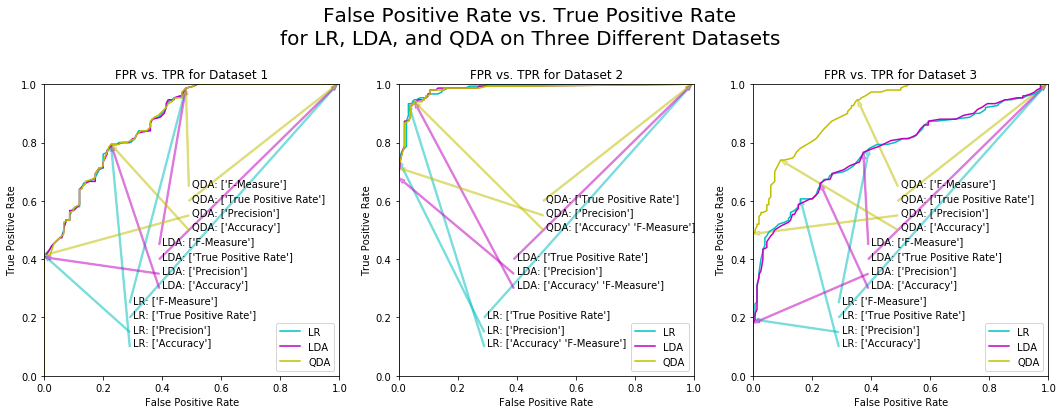

In [17]:
# best_thresholds: a set of thresholds that maximize various metrics in our model
# model: a string that represents a model {LR, LDA, QDA}
# roc: a dataframe with ROC data
# dataset: the number of the dataset associated with the previous parameters
# lx: the desired x-coordinate of the labels for every threshold in best_thresholds
# ly: the desired y-coordinate of the label for the first threshold in best_thresholds
def annotateROC(best_thresholds, model, roc, dataset, lx, ly):
    # offset of label's y-coordinate (for labeling purposes)
    diff = 0
    
    # up to four thresholds per model
    for threshold in best_thresholds[model].unique():
        # find the observation with the threshold in question
        o = roc[roc['Probability Threshold'] == threshold]

        # pull the true/false positive rates from the row
        fpr = np.asscalar(o['False Positive Rate'])
        tpr = np.asscalar(o['True Positive Rate'])

        # save the attributes that `threshold` maximizes and then convert the list to a string
        maximized = best_thresholds[best_thresholds[model] == threshold].index
        maximized = np.array2string(maximized)

        # label the annotated point
        label = model + ': ' + maximized

        # put a label at xytext
        ax[dataset - 1].annotate(label, xy=(fpr, tpr), xytext=(lx, ly + diff))
        
        # the arrow's starting location
        xarrow = lx - 0.01 # just to the left of the label
        yarrow = ly + diff # same y-coordinate as the label
        
        # draw a semi-transparent, colored arrow from the label to the desired point
        ax[dataset - 1].arrow(xarrow, yarrow, fpr - xarrow, tpr - yarrow, alpha=0.4,
            width=0.005, length_includes_head=True, color=colors[model])
        
        # offset the next label's y-coordinate (for readability)
        diff += 0.05

# dataset 1
annotateROC(best_thresholds1, 'LR', roc1_lr, 1, 0.3, 0.1)
annotateROC(best_thresholds1, 'LDA', roc1_lda, 1, 0.4, 0.3)
annotateROC(best_thresholds1, 'QDA', roc1_qda, 1, 0.5, 0.5)

# dataset 2
annotateROC(best_thresholds2, 'LR', roc2_lr, 2, 0.3, 0.1)
annotateROC(best_thresholds2, 'LDA', roc2_lda, 2, 0.4, 0.3)
annotateROC(best_thresholds2, 'QDA', roc2_qda, 2, 0.5, 0.5)

# dataset 3
annotateROC(best_thresholds3, 'LR', roc3_lr, 3, 0.3, 0.1)
annotateROC(best_thresholds3, 'LDA', roc3_lda, 3, 0.4, 0.3)
annotateROC(best_thresholds3, 'QDA', roc3_qda, 3, 0.5, 0.5)

# display the plot
fig

#### What do you notice about the points? Where are they along the ROC curves?

For all models, the highest TPR can be found at the rightmost point of the plot (where FPR is also at its maximum). This makes sense. As we decrease our threshold, we classify more and more points as class 1. At a point, we classify all but one point (because we are avoiding degenerate predictions) as class 1. If $FN=0$ (because our one class 0 prediction is correct), then $TPR=\frac{TP}{TP+FN}=1$.

The highest precision, on the other hand, can be found at the leftmost point on the plot (where TPR and FPR are at their minimum values). This also makes sense. $FPR=\frac{FP}{FP+TN}=0$ when $FP=0$, which occurs when we classify all but one point as class 0 (and we get our one class 1 prediction right). If $FP=0$ and $TP=1$, then $prec=\frac{TP}{TP+FP}=1$.

- Dataset 1
    - F-measure measures the harmonic mean of precision and recall (TPR). The F-measure is maximized when both precision and recall are high. In this dataset, we see that the point where the F-measure is maximized is that in which TPR is about as high as it can go and where FPR is about as low as it can go for this TPR. In other words, the point is at the minimum FPR that gives the maximum TPR. Different thresholds might improve the TPR, but they will significantly increase the FPR.
    - Accuracy is highest when TP and TN are high. For this dataset, we see this at about $(FPR=0.25, TPR=0.75)$. At this point, we can't lower our threshold (to increase TPR) without decreasing our TN (and thus increasing FPR).
- Dataset 2
    - F-measure and accuracy are maximized at the same point (for a given model) in the top left corner. This makes sense because, at this point on such a ROC curve, we have the optimal TPR; any further increase in TPR (by lowering the threshold) will signicantly increase our FPR.
- Dataset 3
    - Like in dataset 1, F-measure is maximized when we can't really get any more TPR gains without significantly increasing our FPR. Note that, although QDA significantly outperforms LR and LDA for this dataset (and thus the ROC curve is shifted), the optimal f-measure (and accuracy) values are at about the same relative points on the curves.
    - Like in dataset 1, our optimal threshold for accuracy is less than 0.5 because that increases our TPR. We can't really decrease our threshold any more, however, without noticeably increasing our FPR, though.

## Step 13:

#### a. For each dataset, describe which model you recommend the school use for their decision-making (and why).
- Dataset 1
    - The three models give extremely similar performance measures. We can see that in our AUC calculations, and we can also see it in our confusion matrices (when comparing the same maximized performance measure). For this reason, any of the models is a valid choice for this dataset. The differences in performance are small enough as to be negligible.
- Dataset 2
    - Again, the three models give extremely similar performance measures for this dataset. However, we can see that, strictly speaking, LDA is slightly better than QDA and LR. For this reason, the school should use LDA for dataset 2. Really, though, any model is fine, and it might be better to use the most efficient model.
- Dataset 3
    - The school should certainly use QDA for this model. As we predicted in step 3, QDA greatly outperforms LR and LDA for this dataset. We expected a quadratric model to fit around class 1 much better than a line, and our ROC curves certainly support this.

#### b. Indicate which probability threshold (or values) you would recommend they set the classifier to use if they wanted to balance the risk of false positives and false negatives.
For all three datasets, we can balance the risk of false positives and false negatives by selecting the threshold that maximizes accuracy. In doing so, we prioritize high true positive and true negative counts, and this will ensure that our false positive and false negative counts are relatively low. In looking at the confusion matrices, we can also see that the false positive and false negative counts are moderately balanced.

It's possibile we could further balance the two values, but this requires further testing, and it's certainly possible the ideal threshold doesn't maximize any of the four performance attributes.